# Partial Configuration Identification


We consider performance analysis in highly variable systems, such as x264, with a large number of configurations options and input features, and multiple performance metrics.
Our goal in this work to identify partial stable configurations from a set of measurements.
A stable configuration is a configuration that is consistently high performing, indicated by its presence in the Pareto front of configurations for each of the videos in the measurement set.
In the ideal case, we identify a single configuration that is present in every Pareto front, i.e. it is never dominated by another configuration. This would be the premier configuration to test for every new input.
Otherwise, we can identify the subset of configurations options that most frequently occur together and propose these as a partial configuration. The extensions of this partial configuration can then form a reduced set of candidate configurations to consider for evaluation/application. The extensions can be similarly determined from the obtained measurements and potentially be weighted by their expected performance resp. their influence on certain performance metrics.

We raise the following research questions:
- Do stable configurations exist? Are they partial or full configurations?
- Do the best configurations share common parameters?
- What is the largest common set of parameters with minimum quality?
- How much do the results vary if we further partition the data, e.g. by video category?
   
Technically speaking, we can apply techniques from data mining, e.g. frequent itemset mining, to determine the core partial configurations, but we do not have to rely on complex statistical machine learning techniques, which makes this approach simple and interpretable.
    
We present an in-depth analysis of our approach on a large-scale dataset of video encodings using the x264 video encoder.
Additionally, we confirm the applicability of our approach on seven others configurable systems (Luc's dataset: gcc, imagemagick, lingeling, nodeJS, poppler, SQLite, xz).

First we import some packages.
`common` is our shared library for shared functions like loading, ranking, etc.

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9
from scipy import stats
from common import load_data, pareto_rank
import os
import json

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import fpgrowth, fpmax

We load the data for one system, here `x264`.

In [2]:
random_state = 1234
test_size = 0.2
(
    perf_matrix,
    input_features,
    config_features,
    all_performances,
    input_preprocessor,
    config_preprocessor,
) = load_data(
    system="x264", data_dir="../data", input_properties_type="tabular"
)
train_inp, test_inp = train_test_split(
    perf_matrix["inputname"].unique(),
    test_size=test_size,
    random_state=random_state,
)
train_perf = perf_matrix[perf_matrix.inputname.isin(train_inp)]
test_perf = perf_matrix[perf_matrix.inputname.isin(test_inp)]

In [3]:
input_features

,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category
inputname,,,,,,,,
Animation_1080P-01b3,1080,1920,1080,0.098,0.004,0.017,0.005,Animation
Animation_1080P-05f8,1080,1920,1080,1.229,0.454,15.962,0.794,Animation
Animation_1080P-0c4f,1080,1920,1080,1.714,0.136,9.048,0.000,Animation
Animation_1080P-0cdf,1080,1920,1080,1.330,0.451,3.677,0.181,Animation
Animation_1080P-18f5,1080,1920,1080,2.452,0.137,3.918,0.329,Animation
...,...,...,...,...,...,...,...,...
Vlog_720P-561e,720,1280,720,2.188,0.034,1.128,0.390,Vlog
Vlog_720P-5d08,720,732,720,4.128,0.285,2.126,0.248,Vlog
Vlog_720P-60f8,720,1280,720,1.554,0.344,2.466,0.250,Vlog


In [4]:
config_features

,cabac,ref,subme,mixed_ref,me_range,trellis,8x8dct,fast_pskip,chroma_qp_offset,bframes,...,analyse,me,direct,deblock,b_adapt,b_pyramid,open_gop,rc_lookahead,scenecut,weightb
configurationID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,16,0,0,1,0,0,...,0:0,dia,NaN,0:0:0,NaN,NaN,NaN,NaN,0.0,NaN
2,1,1,1,0,16,0,1,1,0,3,...,0x3:0x3,dia,auto,1:0:0,1.0,2.0,0.0,NaN,40.0,1.0
3,1,1,2,0,16,0,1,1,0,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,10.0,40.0,1.0
4,1,2,4,0,16,0,1,1,0,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,20.0,40.0,1.0
5,1,2,6,1,16,1,1,1,-2,3,...,0x3:0x113,hex,auto,1:0:0,1.0,2.0,0.0,30.0,40.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,1,16,7,1,24,2,1,0,-2,16,...,0x3:0x133,tesa,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0
198,1,16,11,1,24,2,1,0,-2,16,...,0x3:0x133,hex,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0
199,1,16,11,1,24,2,1,0,-2,16,...,0x3:0x3,tesa,spatial,1:0:0,2.0,2.0,0.0,60.0,40.0,1.0


## Pareto Front Calculation

We take the matrix of all measurements and calculate the Pareto ranks for each configuration per input. For this, we consider all measured performances, but we can change this to any subset.

In [5]:
performances = ["fps", "cpu"]
performances = ["size", "etime"]
icm = (
    train_perf[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_ranked_measures = icm.groupby(
    "inputname"
).transform(  # Go from measured values to ranks within each input group
    lambda x: stats.rankdata(x, method="min")
)
icm["ranks"] = icm.groupby("inputname", group_keys=False).apply(pareto_rank)

# Calculate the Pareto ranks for the test data
icm_test = (
    test_perf[["inputname", "configurationID"] + performances]
    .sort_values(["inputname", "configurationID"])
    .set_index(["inputname", "configurationID"])
)
icm_test["ranks"] = icm_test.groupby("inputname", group_keys=False).apply(pareto_rank)
icm_test

size  etime  ranks
inputname           configurationID                       
Animation_360P-5712 1                3081149   0.36      6
                    2                2055473   0.38      3
                    3                1276380   0.48      1
                    4                1297457   0.53      3
                    5                1341943   0.60      8
...                                      ...    ...    ...
Vlog_720P-561e      197              4357532  13.52     26
                    198              4047631  11.03     19
                    199              4048330  15.81     23
                    200              4048330  15.77     22
                    201              5050034  14.59     29

[51858 rows x 3 columns]

For quick visualization, we plot the distribution of measurements and their ranks for one input.
The first Pareto front is in the lower left corner.

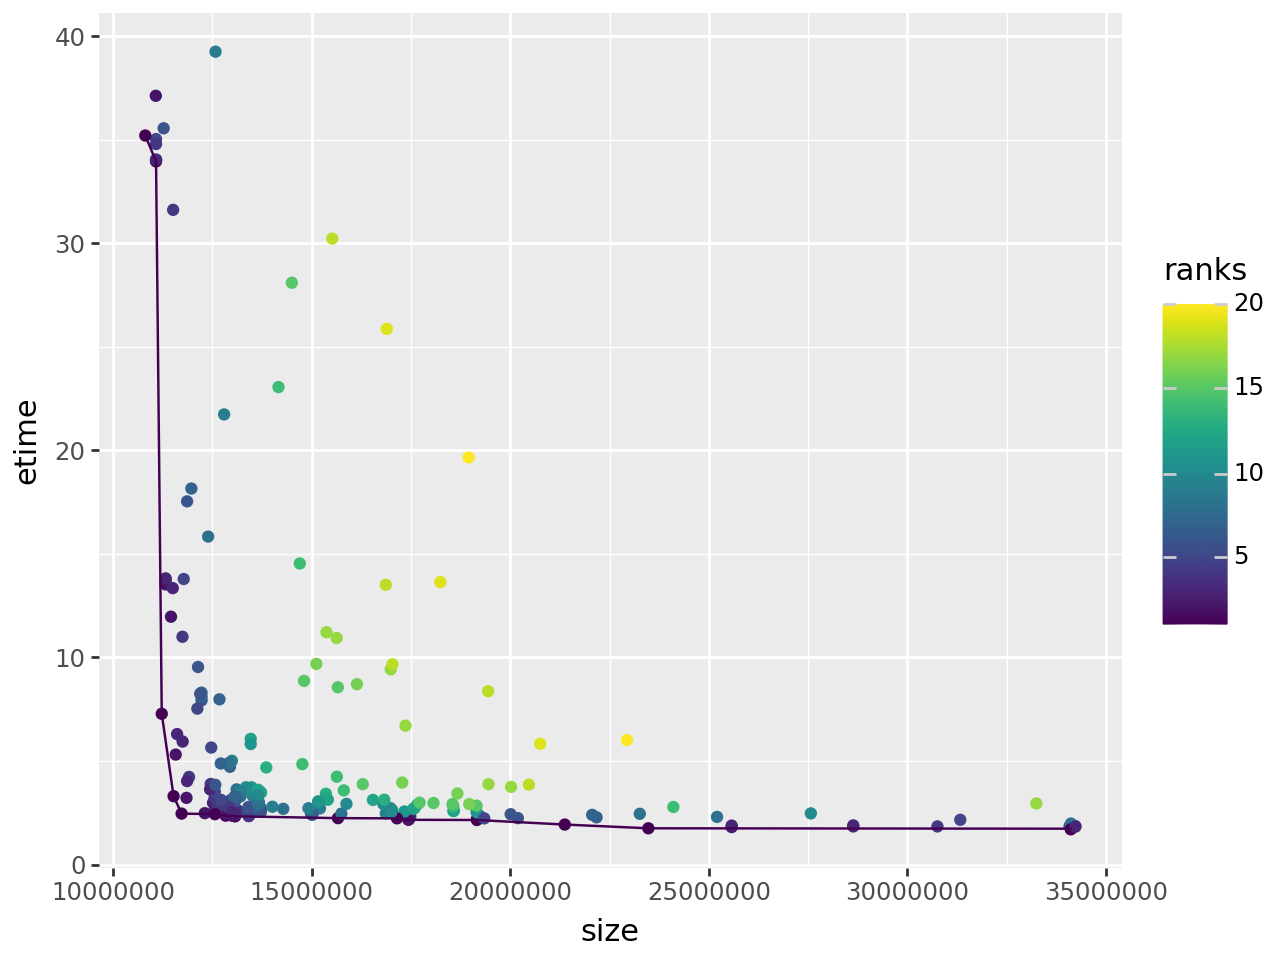

In [6]:
(
    p9.ggplot(icm.loc[("Animation_1080P-0c4f")], p9.aes(x="size", y="etime", color="ranks"))
    + p9.geom_point()
    + p9.geom_line(icm[icm.ranks == 1].loc[("Animation_1080P-0c4f")])
)

Let's look at the distribution of the ranks. How many ranks are there and how large are they over all inputs?

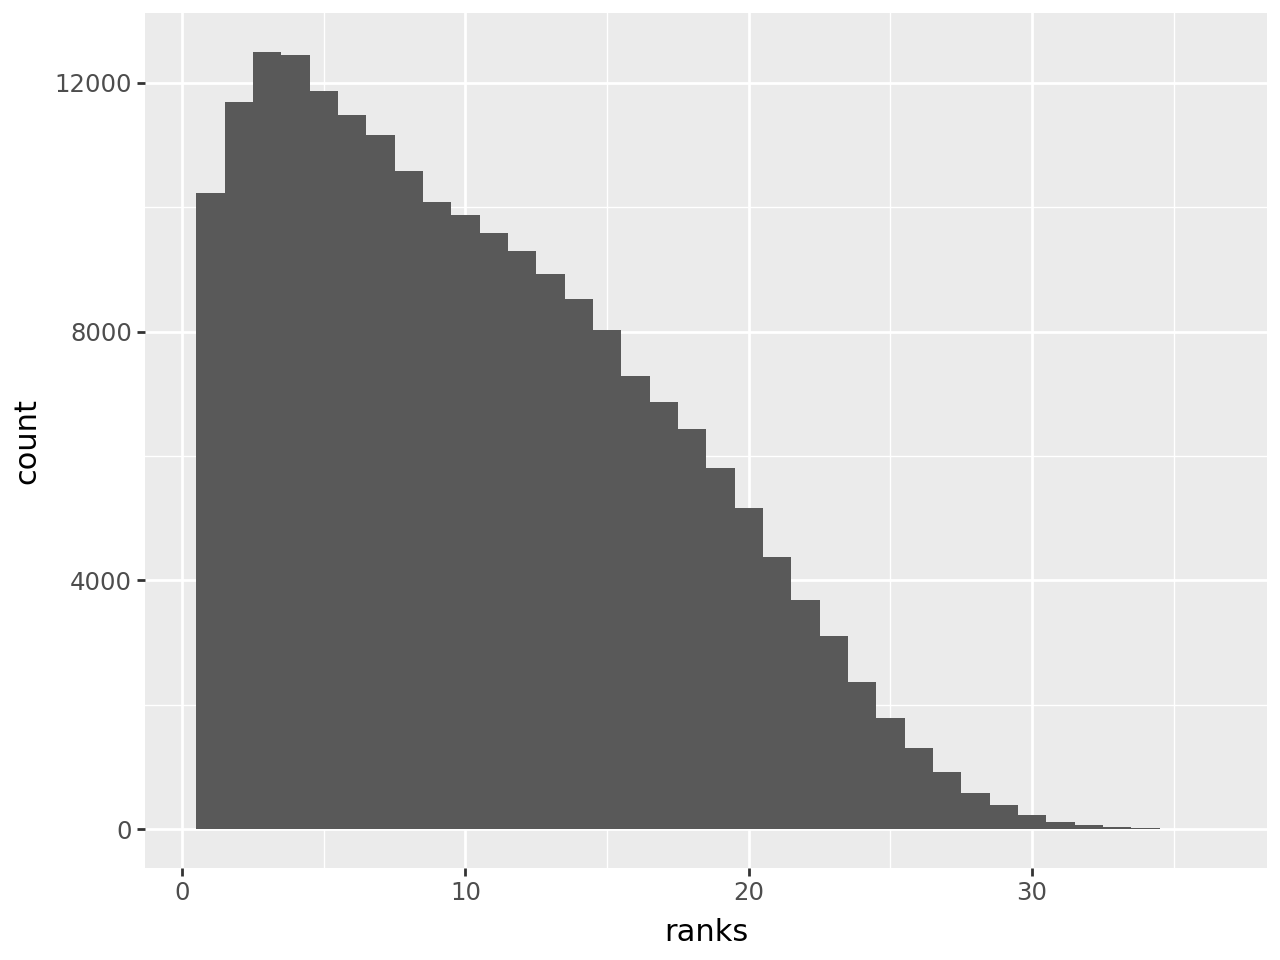

In [7]:
(
    p9.ggplot(icm, p9.aes(x="ranks"))
    + p9.geom_histogram(binwidth=1)
)

For further mining, we are only interested in the best performing configurations, i.e. the top Pareto ranks.

In [8]:
subdf = icm[icm.ranks <= 1]
subdf

size  etime  ranks
inputname            configurationID                        
Animation_1080P-01b3 12                 391980   2.12      1
                     14                 403085   2.11      1
                     19                 362215   2.20      1
                     58                 164452   2.41      1
                     68                 155859   2.65      1
...                                        ...    ...    ...
Vlog_720P-6d56       50               12110689   1.53      1
                     64               10156245   1.85      1
                     71                9123722   2.03      1
                     72                9073822   2.22      1
                     79               10220122   1.55      1

[10221 rows x 3 columns]

For the `mlxtend` itemset mining functionality, it is necessary to convert the dataset to onehot encoding.

In [9]:
def prepare(dataset):
    enc = OneHotEncoder(
        min_frequency=1,
        handle_unknown="infrequent_if_exist",
        sparse_output=False,
    )
    enc.fit(dataset)
    col_names = enc.get_feature_names_out()
    onehot_data = enc.transform(dataset)

    df = pd.DataFrame(onehot_data, columns=col_names, dtype=np.bool_)
    return df

dataset = subdf.join(config_features).join(input_features).reset_index()

df = prepare(dataset[config_features.columns])
print(f"One-hot encoded dataset has {df.shape[1]} columns ({dataset.shape[1]} before)")
df

One-hot encoded dataset has 78 columns (37 before)


,cabac_0,cabac_1,ref_1,ref_2,ref_3,ref_5,ref_7,ref_8,ref_16,subme_0,...,rc_lookahead_30.0,rc_lookahead_40.0,rc_lookahead_50.0,rc_lookahead_60.0,rc_lookahead_nan,scenecut_0.0,scenecut_40.0,scenecut_nan,weightb_1.0,weightb_nan
0,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,True
1,True,False,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
2,False,True,True,False,False,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,True
3,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
4,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10216,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,True,False
10217,False,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
10218,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
10219,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


In [10]:
subdf.shape, dataset.shape

((10221, 3), (10221, 37))

## FP-Growth
Extracting frequent itemsets from a dataset, i.e. which items to appear together most commonly.
We see that this gives us a lot of small itemsets, even though we are interested in the _largest_ partial configuration we can find.

In [11]:
growthdf = fpgrowth(df, min_support=0.6, use_colnames=True).sort_values("support", ascending=False)
growthdf

,support,itemsets
0,1.000000,(qpmax_69)
1,0.936699,(fast_pskip_1)
11,0.936699,"(fast_pskip_1, qpmax_69)"
2,0.916251,(trellis_0)
12,0.916251,"(qpmax_69, trellis_0)"
...,...,...
119,0.605127,"(cabac_1, qpmax_69, me_range_16)"
99,0.603757,"(ref_1, qpmax_69)"
7,0.603757,(ref_1)
79,0.601702,"(fast_pskip_1, qpmax_69, deblock_1:0:0, me_ran..."


## FP-Max 

FP-Max is a variant of FP-Growth, which focuses on obtaining maximal itemsets. 
An itemset X is said to maximal if X is frequent and there exists no frequent super-pattern containing X. 
In other words, a frequent pattern X cannot be sub-pattern of larger frequent pattern to qualify for the definition maximal itemset.

In [12]:
maxsets = fpmax(df, min_support=0.2, use_colnames=True).sort_values("support", ascending=False)
maxsets["length"] = maxsets["itemsets"].apply(len)
maxsets

,support,itemsets,length
782,0.266217,"(ref_1, chroma_qp_offset_0, fast_pskip_1, mbtr...",10
788,0.265825,"(chroma_qp_offset_0, deblock_1:0:0, fast_pskip...",9
737,0.240583,"(cabac_1, chroma_qp_offset_0, 8x8dct_1, debloc...",10
736,0.230701,"(cabac_1, chroma_qp_offset_0, deblock_1:0:0, a...",10
246,0.225907,"(ref_1, chroma_qp_offset_0, deblock_1:0:0, fas...",8
...,...,...,...
758,0.200078,"(ref_1, chroma_qp_offset_0, scenecut_40.0, 8x8...",9
190,0.200078,"(ref_1, chroma_qp_offset_0, open_gop_nan, weig...",16
161,0.200078,"(ref_1, chroma_qp_offset_0, open_gop_nan, weig...",14
149,0.200078,"(ref_1, direct_nan, analyse_0:0, scenecut_0.0,...",12


In [13]:
allinds = set()
itemsets = []
for i, r in enumerate(maxsets.itemsets):
    if allinds.issuperset(df[df[r].all(axis=1)].index):
        continue

    allinds.update(df[df[r].all(axis=1)].index)
    itemsets.append(r)
    print(i, len(allinds)/df.shape[0])

print(f"Covered {len(allinds)/df.shape[0]*100:.4f}% of the dataset with {len(itemsets)} configurations")

0 0.26621661285588494
1 0.3870462772722826
2 0.5231386361412778
3 0.5830153605322376
4 0.6495450542999707
5 0.6788963897857353
7 0.7306525780256335
8 0.746600136972899
11 0.7943449760297426
13 0.8003130809118482
14 0.8682125036689169
16 0.876430877604931
19 0.8840622248312299
24 0.9040211329615497
34 0.9138049114568046
36 0.9324919283827414
38 0.9335681440172194
39 0.9448194892867625
48 0.9468740827707661
75 0.9522551609431562
81 0.9575384013305939
103 0.9584189413951668
110 0.9585167791801193
125 0.9587124547500244
149 0.9633108306427942
154 0.9658546130515605
175 0.9664416397612758
198 0.9786713628803444
212 0.9787692006652969
226 0.9833675765580667
263 0.9841502788376871
299 0.9871832501712161
330 0.9903140592896977
344 0.9929556794834165
446 0.9941297329028471
470 0.9954016241072302
509 0.9954994618921827
577 0.995890813031993
580 0.9964778397417082
666 0.9973583798062812
Covered 99.7358% of the dataset with 40 configurations


In [14]:
allinds = set()
itemsets = []
for i, r in enumerate(maxsets.itemsets):
    covered_rows = df[r].all(axis=1).values
    if allinds.issuperset(dataset[covered_rows].inputname):
        continue

    allinds.update(dataset[covered_rows].inputname)
    itemsets.append(r)
    print(i, len(allinds)/dataset.inputname.nunique())

print(f"Covered {len(allinds)/dataset.inputname.nunique()*100:.4f}% of the inputs with {len(itemsets)} partial configurations")

0 0.9572400388726919
1 0.9941690962099126
2 0.9980563654033042
3 0.9990281827016521
34 1.0
Covered 100.0000% of the inputs with 5 partial configurations


In [15]:
covered_rows = df[itemsets[0]].all(axis=1).values
static_features = dataset[covered_rows][config_features.columns].nunique() == 1
static_features = static_features[static_features].index.tolist()
variable_features = [c for c in config_features.columns if c not in static_features]
static_features

['ref',
 'mixed_ref',
 'me_range',
 'trellis',
 'fast_pskip',
 'chroma_qp_offset',
 'mbtree',
 'qpmax',
 'me',
 'b_adapt',
 'b_pyramid',
 'open_gop',
 'weightb']

In [16]:
dataset[covered_rows].groupby(variable_features).count()

,,,,,,,,,,,inputname,configurationID,size,etime,ranks,ref,mixed_ref,me_range,trellis,fast_pskip,...,open_gop,weightb,resolution,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,category
cabac,subme,8x8dct,bframes,weightp,aq-mode,analyse,direct,deblock,rc_lookahead,scenecut,,,,,,,,,,,,,,,,,,,,,


In [17]:
dataset[covered_rows][config_features.columns].nunique()[dataset[covered_rows][config_features.columns].nunique() > 1]

cabac       2
subme       4
8x8dct      2
bframes     3
weightp     3
aq-mode     2
analyse     3
direct      2
deblock     2
scenecut    2
dtype: int64

In [18]:
cfg_columns = ["configurationID"] + list(config_features.columns)
top_cfgs = dataset[cfg_columns + ["inputname"]].groupby(cfg_columns, dropna=False, as_index=False).count().sort_values(
    "inputname", ascending=False
).configurationID.tolist()

In [114]:
## Here we select the configurations by decreasing coverage
# If a configuration adds new items, we add it.
# We repeat until all inputs are covered.

covered_inputs = set()
num_inputs = subdf.reset_index().inputname.nunique()
input_labels = pd.Series(np.zeros(num_inputs), index=dataset.inputname.unique())
selected_configs = []

for cid in top_cfgs:
    inputnames = subdf.reset_index().query("configurationID == @cid").inputname.unique()
    new_inputs = set(inputnames).difference(covered_inputs)
    input_labels[list(new_inputs)] = cid
    covered_inputs.update(new_inputs)
    selected_configs.append(cid)

    if len(covered_inputs) == num_inputs:
        print(f"Reached full coverage with {len(selected_configs)} configurations")
        break


Reached full coverage with 47 configurations


In [163]:
## Here we select the configurations by maximal gain
# We iterate over all open configurations and add that which adds the most input coverage.
# We repeat until all inputs are covered.
# The code could be more efficient, but it's good enough for x264

covered_inputs = set()
num_inputs = subdf.reset_index().inputname.nunique()
input_labels = pd.Series(np.zeros(num_inputs), index=dataset.inputname.unique())
selected_configs = []
open_cfg = np.ones(len(top_cfgs), dtype=np.bool_)

while len(covered_inputs)/num_inputs < 1.0:
    max_add = 0
    max_add_id = -1
    
    for i in np.where(open_cfg)[0]:
        cid = top_cfgs[i]
        inputnames = subdf.reset_index().query("configurationID == @cid").inputname.unique()
        new_inputs = set(inputnames).difference(covered_inputs)
    
        if len(new_inputs) == 0:
            open_cfg[i] = False

        if len(new_inputs) > max_add:
            max_add = len(new_inputs)
            max_add_id = i

    cid = top_cfgs[max_add_id]
    inputnames = subdf.reset_index().query("configurationID == @cid").inputname.unique()
    new_inputs = set(inputnames).difference(covered_inputs)
    input_labels[list(new_inputs)] = cid
    open_cfg[max_add_id] = False
    covered_inputs.update(new_inputs)
    selected_configs.append(cid)

    print(len(covered_inputs)/num_inputs)

print(f"Reached full coverage with {len(selected_configs)} configurations")

0.49076773566569487
0.7424684159378037
0.8688046647230321
0.9271137026239067
0.9659863945578231
0.9776482021379981
0.9863945578231292
0.9922254616132167
0.9951409135082604
0.9980563654033042
0.9990281827016521
1.0
Reached full coverage with 12 configurations


In [167]:
y.max()

11

In [168]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

input_labels = input_labels.sort_index()
enc = LabelEncoder()
y = enc.fit_transform(input_labels)

X = input_preprocessor.fit_transform(
    input_features.query("inputname.isin(@input_labels.index)").sort_index()
)

# train_idx, val_idx = train_test_split(np.arange(X.shape[0]), test_size=0.2)
# X_train = X[train_idx]
# X_val = X[val_idx]
# y_train = y[train_idx]
# y_val = y[val_idx]
# inputnames_val = input_labels.index[val_idx]

X_train = X
y_train = y
X_val = X
y_val = y
inputnames_val = input_labels.index

for i in range(1, 10):
    print(i)
    clf = DecisionTreeClassifier(max_depth=i)
    # clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred_cfg_lbl = clf.predict(X_val)
    pred_cfg = enc.inverse_transform(pred_cfg_lbl).astype(int)

    print("Scores", clf.score(X_train, y_train), clf.score(X_val, y_val))

    # Validation test
    inp_pred_map = pd.DataFrame(zip(inputnames_val, pred_cfg), columns=["inputname", "configurationID"])
    print("Val rank", icm.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean())

    # Test set
    X_test = input_preprocessor.transform(input_features.query("inputname.isin(@test_inp)"))
    pred_cfg = enc.inverse_transform(clf.predict(X_test)).astype(int)

    inp_pred_map = pd.DataFrame(zip(test_inp, pred_cfg), columns=["inputname", "configurationID"])
    print("Test rank", icm_test.merge(inp_pred_map, on=["inputname", "configurationID"])["ranks"].mean())
    print("")

1
Scores 0.564625850340136 0.564625850340136
Val rank 2.3517978620019435
Test rank 3.2674418604651163

2
Scores 0.5908649173955296 0.5908649173955296
Val rank 2.0816326530612246
Test rank 3.3488372093023258

3
Scores 0.6103012633624878 0.6103012633624878
Val rank 1.881438289601555
Test rank 3.352713178294574

4
Scores 0.652089407191448 0.652089407191448
Val rank 1.8027210884353742
Test rank 3.2674418604651163

5
Scores 0.6870748299319728 0.6870748299319728
Val rank 1.7259475218658893
Test rank 3.2829457364341086

6
Scores 0.7278911564625851 0.7278911564625851
Val rank 1.6093294460641399
Test rank 3.4767441860465116

7
Scores 0.760932944606414 0.760932944606414
Val rank 1.4927113702623906
Test rank 3.5775193798449614

8
Scores 0.7871720116618076 0.7871720116618076
Val rank 1.4412050534499514
Test rank 3.488372093023256

9
Scores 0.8250728862973761 0.8250728862973761
Val rank 1.3615160349854227
Test rank 3.4573643410852712



In [98]:
## These are our evaluation baselines
# The best configuration by averaging the ranks over all inputs
best_cfg_id_overall = icm[["ranks"]].groupby("configurationID").mean().idxmin().item()

# The best configuration per performance metric
best_cfg_id_per_metric = icm_ranked_measures.groupby("configurationID").mean().idxmin()

# The most common configuration in the Pareto fronts
most_common_cfg_id = (
    dataset[["configurationID"] + [config_features.columns[0]]]
    .groupby(["configurationID"], as_index=False)
    .count()
    .sort_values(by=config_features.columns[0], ascending=False)
    .iloc[0]
    .configurationID
)

In [99]:
overall_ranks = icm_test.query("configurationID == @best_cfg_id_overall").ranks
print(f"Average rank of the overall best configuration: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")

for p in performances:
    cfg_id = best_cfg_id_per_metric[p]
    overall_ranks = icm_test.query("configurationID == @cfg_id").ranks
    print(f"Average rank of the best configuration for {p}: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")

overall_ranks = icm_test.query("configurationID.isin(@best_cfg_id_per_metric.values)").ranks
print(f"Average rank of the best configuration for all metrics: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")

overall_ranks = icm_test.query("configurationID == @most_common_cfg_id").ranks
print(f"Average rank of the most common configuration: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")

# TODO Not sure std. dev. is correct here. We sample all random configs at once.
random_ranks = np.random.randint(0, test_perf.configurationID.max(), 10) + 1
overall_ranks = icm_test.query("configurationID.isin(@random_ranks)").ranks
print(f"Average rank of random configuration: {overall_ranks.mean():.2f}+-{overall_ranks.std():.2f}")


Average rank of the overall best configuration: 2.10+-1.84
Average rank of the best configuration for size: 3.60+-3.17
Average rank of the best configuration for etime: 3.95+-2.25
Average rank of the best configuration for all metrics: 3.78+-2.75
Average rank of the most common configuration: 3.07+-2.96
Average rank of random configuration: 12.21+-6.57


In [ ]:
part_dataset = dataset[(dataset.COLOR_COMPLEXITY < 0.01) & (dataset.CHUNK_COMPLEXITY_VARIATION < 0.008)]

if part_dataset[input_features.columns].drop_duplicates().shape[0] == 1:
    print("Constant dataframe")

cdf = prepare(part_dataset[config_features.columns])
maxsets = fpmax(cdf, min_support=0.6, use_colnames=True).sort_values("support", ascending=False)
maxsets["length"] = maxsets["itemsets"].apply(len)
maxsets["num_measurements"] = maxsets["support"] * cdf.shape[0]
maxsets

## Open Questions

- How do the itemsets change if we partition the data? E.g. by input features like category
- How do the itemsets change if we vary the pareto rank?
- What will we observe on the other datasets?
- What do we take away from the results?
- How can it be presented?

Orthogonal to the question of "What configuration options appear the most in the Pareto fronts" is the question of "What full configurations are the most common in the Pareto fronts":
This we should be able to answer by looking at the largest itemset we can find; here it's interesting to compare it's length to the number of configuration options.